## Desafío 3 - DH - ML Clasificación

<a id="tabla_contenidos"></a> 
### Tabla de Contenidos

#### <a href='#section_proposito'>0. Propósito de esta Notebook</a>
- ##### <a href='#section_motivacion'>0.1 Motivación</a>
- ##### <a href='#section_dataset_info'>0.2 Detalles del Dataset</a>
- ##### <a href='#section_antecedentes'>0.3 Trabajos Previos</a>

#### <a href='#section_preparacion'>1. Estudio del Dataset</a>
- ##### <a href='#section_importacion'>1.1 Importación</a>
- ##### <a href='#section_analisis'>1.2 Análisis Exploratorio</a>
- ##### <a href='#section_split'>1.3 Selección de Target</a>

#### <a href='#section_algoritmos'>2. Algoritmos y predicción</a>
- ##### <a href='#acon_dataset'>2.1 Acondicionamiento del Dataset</a>
- ##### <a href='#knn'>2.2 K Nearest Neighbors (KNN)</a>
- ##### <a href='#reg_log'>2.3 Regresión Logística</a>
- ##### <a href='#resultados'>2.4 Comparación de Resultados</a>

#### <a href='#section_consolidacion'>3. Consolidación</a>
- ##### <a href='#pipe'>3.1 Pipelines</a>
- ##### <a href='#conclusion'>3.2 Conclusión</a>

<hr>

## <a id='section_proposito'>0. Propósito de esta Notebook</a>

### <a id="section_motivacion">0.1 Motivación</a> 

A traves del portal data.buenosaires.gob.ar, el gobierno de la Ciudad Autónoma de Buenos Aires facilita la búsqueda, acceso y descubrimiento de datos producidos localmente, promoviendo la generacion de valor con los mismos. El dataset 'Test de Alerta sobre un noviazgo violento' contiene respuestas anónimas a una encuesta que busca concientizar sobre relaciones que pueden tender hacia la violencia. La encuesta esta compuesta por 13 preguntas, disponibles en el github del gobierno de la ciudad. En este desafío implementamos y presentamos un clasificador que puede predecir la respuesta de la pregunta 13, utilizando el resto de las preguntas, con la posibilidad de que en futuros trabajos se pueda enriquecer el clasificador con mas datos.

### <a id="section_dataset_info">0.2 Detalles del Dataset</a>

#### Listado de preguntas

- 1. Cuando no están juntos/as, ¿tu pareja te controla preguntándote con quién estás, dónde y qué estás haciendo mensajeándote por celular?
- 2. ¿Revisa los mensajes de tu celular o te pidió la contraseña de tu correo electrónico, Facebook o Instagram como “prueba de confianza”?
- 3. ¿Te acusa de haber sido infiel o coquetear con otras/os?
- 4. ¿Sentís que están permanentemente en tensión y que, hagas lo que hagas, se irrita o te culpabiliza de sus cambios de humor?
- 5. ¿Le molesta que hagas actividades de manera independiente, como estudiar, trabajar, visitar amigos/as, ir al gimnasio o elegir quedarte solo/a en tu casa?
- 6. ¿Sentís que te alejaste o perdiste contacto con amigos/as o familiares desde que estás en pareja?
- 7. ¿Te dice cómo tenés que vestirte o cómo debe ser tu apariencia?
- 8. ¿Menosprecia en público o en privado tus opiniones?
- 9. ¿Te dice que todo lo que hacés está mal o que no servís para nada?
- 10. ¿Te amenaza con lastimarse/te si no lo/la obedecés o si querés terminar la relación?
- 11. Después de un episodio violento, ¿se muestra cariñoso/a o atento/a y promete que nunca más lo hará y todo cambiará?
- 12. ¿Indaga o cuestiona tus noviazgos anteriores?
- 13. ¿Te sentís presionado/a a realizar determinadas prácticas sexuales por temor a que te deje?

#### Listado de respuestas

- A = Siempre
- B = A veces
- C = Nunca

## <a id='section_antecedentes'>0.3 Trabajos Previos</a>

Existen diversidad de trabajos previos relacionados con este, en primera instancia el test en si mismo y otros que listamos a continuacion:
##### <a href='https://datosgcba.github.io/curso-datos/trabajos/noviazgos.html'>Noviazgos violentos en la Ciudad de Buenos Aires, 2019</a>
##### <a href='https://blog.properati.com.ar/en-que-barrios-las-mujeres-sufren-mas-violencia-en-sus-noviazgos/'>¿En qué barrios las mujeres sufren más violencia en sus noviazgos?, 2018</a>

<hr>

<a id='section_preparacion'></a> 
## 1. Preparación del Dataset

### <a id="section_importacion">1.1 Importación de datos</a> 

### Importación de datos de población y resultados de encuesta
Los datos de población nos permitirán realizar una exploración geográfica de la ubicación de los encuestados

In [1]:
# librerías
import numpy as np
import pandas as pd
import unicodedata

In [2]:
resultados_del_test = pd.read_csv("data/resultados-del-test.csv", delimiter = ",")

In [3]:
poblacion_por_barrio = pd.read_csv("data/caba_pob_barrios_2010.csv")

#### Unifico en un dataset
Elimino tildes en los nombres de los barrios de cada dataset y agrego población por barrio al resultado de las encuestas

In [4]:
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s

In [5]:
poblacion_por_barrio.BARRIO = poblacion_por_barrio.BARRIO.apply(elimina_tildes).apply(lambda barrio: barrio.capitalize())

In [6]:
resultados_del_test.barrio = resultados_del_test.barrio.apply(elimina_tildes).apply(lambda barrio: barrio.capitalize())

In [7]:
poblacion_por_barrio.columns = ['barrio', 'poblacion']

In [8]:
poblacion_por_barrio = poblacion_por_barrio.set_index('barrio')

In [9]:
def obtener_poblacion_por_barrio(barrio):
    return poblacion_por_barrio.loc[barrio].poblacion

In [10]:
# la imputación unifica denominaciónes y rellena 'Otro' con un barrio aleatorio

def imputar_barrio(barrio):
    barrios = poblacion_por_barrio.index.tolist()
    if barrio == "La boca": return "Boca"
    if barrio == "Montserrat": return "Monserrat"
    if barrio == "Villa general mitre": return "Villa gral. mitre"
    if barrio == "La paternal": return "Paternal"
    if barrio == "Otro": return np.random.choice(barrios)
    return barrio

In [11]:
resultados_del_test["barrio_completo"] = resultados_del_test.barrio.apply(imputar_barrio)

In [12]:
resultados_del_test["poblacion_por_barrio"] = resultados_del_test.barrio_completo.apply(obtener_poblacion_por_barrio)

#### Exporto y resguardo el dataset unificado

In [13]:
resultados_del_test.to_csv("data/dataset_joined.csv")

## <a id="section_analisis">1.2 Análisis Exploratorio</a> 

Importo el dataset unificado

In [14]:
dataset = pd.read_csv("data/dataset_joined.csv", delimiter = ",",  index_col = "Unnamed: 0")
dataset.head(3)

,fecha,hora,edad,genero,barrio,pregunta_1,pregunta_2,pregunta_3,pregunta_4,pregunta_5,pregunta_6,pregunta_7,pregunta_8,pregunta_9,pregunta_10,pregunta_11,pregunta_12,pregunta_13,barrio_completo,poblacion_por_barrio
0,2019-06-14,09:09:00,27,Mujer,Constitucion,A,A,A,B,A,B,C,C,B,C,B,C,C,Constitucion,44107
1,2019-06-13,23:20:00,17,Mujer,Otro,A,B,B,B,B,C,C,B,B,C,B,C,C,Villa devoto,66521
2,2019-06-13,16:33:00,15,Mujer,Recoleta,B,B,C,B,C,B,B,A,A,A,A,A,A,Recoleta,157932


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5676 entries, 0 to 5675
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fecha                 5676 non-null   object
 1   hora                  5676 non-null   object
 2   edad                  5676 non-null   int64 
 3   genero                5676 non-null   object
 4   barrio                5676 non-null   object
 5   pregunta_1            5676 non-null   object
 6   pregunta_2            5676 non-null   object
 7   pregunta_3            5676 non-null   object
 8   pregunta_4            5676 non-null   object
 9   pregunta_5            5676 non-null   object
 10  pregunta_6            5676 non-null   object
 11  pregunta_7            5676 non-null   object
 12  pregunta_8            5676 non-null   object
 13  pregunta_9            5676 non-null   object
 14  pregunta_10           5676 non-null   object
 15  pregunta_11           5676 non-null   

### Visualizamos los nulos

In [16]:
### librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
dataset_columnas = dataset[["fecha",'edad', 'genero', 'barrio','barrio_completo','poblacion_por_barrio']]

In [18]:
from IPython.display import Markdown, display

nulls_by_column = dataset_columnas.isnull().sum()
dataset_size = dataset.shape[0]

for column in nulls_by_column.index:
    column_nulls = nulls_by_column[column]
    null_percentage = 100 * column_nulls / dataset_size
    display(Markdown(f"* ```{column}``` tiene {column_nulls} nulos, lo cual representa el {null_percentage:.2f}%"))

* ```fecha``` tiene 0 nulos, lo cual representa el 0.00%

* ```edad``` tiene 0 nulos, lo cual representa el 0.00%

* ```genero``` tiene 0 nulos, lo cual representa el 0.00%

* ```barrio``` tiene 0 nulos, lo cual representa el 0.00%

* ```barrio_completo``` tiene 0 nulos, lo cual representa el 0.00%

* ```poblacion_por_barrio``` tiene 0 nulos, lo cual representa el 0.00%

### Barrio de los encuestados

In [19]:
# algunos de los barrios imputados en 'Otro'
dataset.loc[dataset.barrio == 'Otro','barrio_completo'].head(10)

1         Villa devoto
8      Velez sarsfield
9             Belgrano
10          Colegiales
16            Recoleta
18        Villa devoto
24     Villa riachuelo
25           Monserrat
26            Floresta
32    Parque patricios
Name: barrio_completo, dtype: object

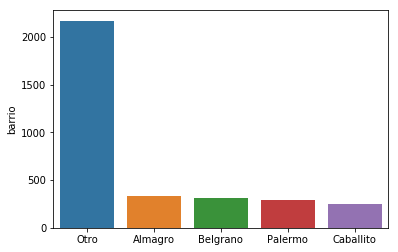

In [20]:
# barrios sin imputaciones
sns.barplot(x=dataset.barrio.value_counts().head(5).index, y=dataset.barrio.value_counts().head(5))

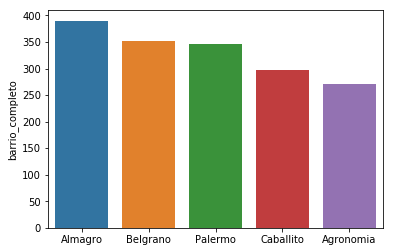

In [21]:
# barrios con imputaciones
sns.barplot(x=dataset.barrio_completo.value_counts().head(5).index, y=dataset.barrio_completo.value_counts().head(5))

#### Vemos los primeros quince barrios con más encuestados

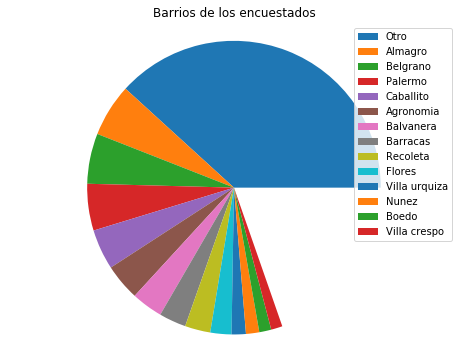

In [22]:
labels = dataset.barrio.value_counts(normalize=True).index[:14]
sizes = list(dataset.barrio.value_counts(normalize=True)[:14])

figura, axis = plt.subplots(figsize=(8,6))
axis.pie(sizes)
axis.axis('equal') 
axis.set_title('Barrios de los encuestados')
axis.legend(labels)

### Edades de los encuestados

#### Visualizamos las edades y sus outliers

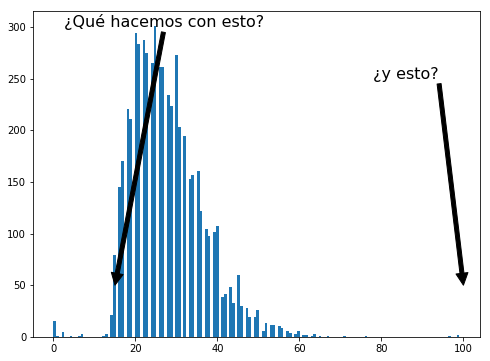

In [23]:
plt.figure(figsize=(8, 6))
plt.hist(dataset.edad, bins=150);
plt.annotate('¿Qué hacemos con esto?', xy=(15, 50), xytext=(2.5, 300),arrowprops=dict(facecolor='black', shrink=15), fontsize=16)
plt.annotate('¿y esto?', xy=(100, 50), xytext=(78, 250), arrowprops=dict(facecolor='black', shrink=15), fontsize=16);
plt.show()

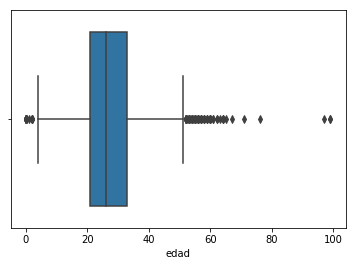

In [24]:
sns.boxplot(dataset.edad)

#### Quitamos los outliers<br>
Vemos cómo quedaria la distribución si usamos los rangos intercuartiles para quitar outliers.

In [25]:
dataset_edad = dataset["edad"]


El skew es 0.5893768101027447 cuando quitamos los outliers


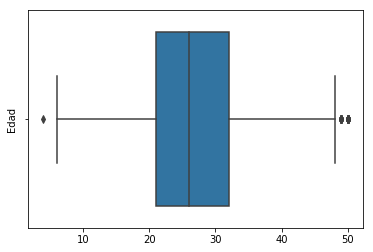

In [26]:
q1 = dataset_edad.quantile(0.25)
q2 = dataset_edad.quantile(0.5)
q3 = dataset_edad.quantile(0.75)

iqr = q3 - q1

up_threshold = q3 + 1.5 * iqr
low_threshold = q1 - 1.5* iqr

no_outliers_mask = (dataset_edad > low_threshold) & (dataset_edad < up_threshold)

ax = sns.boxplot(dataset_edad[no_outliers_mask], orient = 'h').set(
    xlabel='', 
    ylabel='Edad'
)
print(f"\nEl skew es {dataset_edad[no_outliers_mask].skew()} cuando quitamos los outliers")

In [27]:
n_without_outliers = dataset_edad[no_outliers_mask].shape[0]
n_including_outliers = dataset_edad.shape[0]

taken_percentage = 100 * n_without_outliers / n_including_outliers
print(f"""
Sin outliers hemos tomado un {taken_percentage:.2f}% de los datos que teníamos, considerando solamente {n_including_outliers - n_without_outliers} registros como outliers.""")


Sin outliers hemos tomado un 97.97% de los datos que teníamos, considerando solamente 115 registros como outliers.


### Género de encuestados

In [28]:
dataset["genero"].value_counts()

Mujer     4736
Hombre     912
Otro        28
Name: genero, dtype: int64

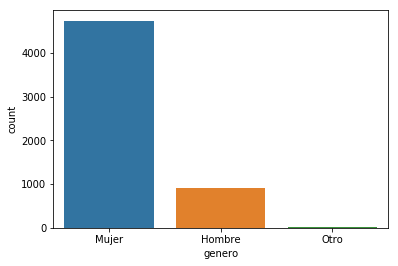

In [29]:
sns.countplot(x='genero', data=dataset)

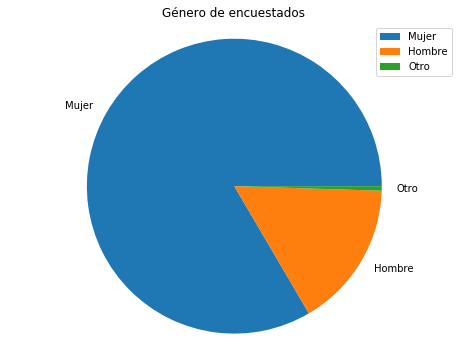

In [30]:
labels = dataset.genero.value_counts(normalize=True).index
sizes = list(dataset.genero.value_counts(normalize=True))

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(sizes, labels=labels)
ax1.axis('equal') 
ax1.set_title('Género de encuestados')
ax1.legend()

### Respuestas

In [157]:
preguntas = ['1. ¿Cuando no están juntos/as, ¿tu pareja te controla preguntándote con quién estás,<br> dónde y qué estás haciendo mensajeándote por celular?', 
 '2. ¿Revisa los mensajes de tu celular o te pidió la contraseña de tu correo electrónico,<br> Facebook o Instagram como “prueba de confianza”?',
 '3. ¿Te acusa de haber sido infiel o coquetear con otras/os?',
 '4. ¿Sentís que están permanentemente en tensión y que, hagas lo que hagas, se irrita<br> o te culpabiliza de sus cambios de humor?',
 '5. ¿Le molesta que hagas actividades de manera independiente, como estudiar, trabajar,<br> visitar amigos/as, ir al gimnasio o elegir quedarte solo/a en tu casa?',
 '6. ¿Sentís que te alejaste o perdiste contacto con amigos/as o familiares desde que estás en pareja?',
 '7. ¿Te dice cómo tenés que vestirte o cómo debe ser tu apariencia?',
 '8. ¿Menosprecia en público o en privado tus opiniones?',
 '9. ¿Te dice que todo lo que hacés está mal o que no servís para nada?',
 '10. ¿Te amenaza con lastimarse/te si no lo/la obedecés o si querés terminar la relación?',
 '11. Después de un episodio violento, ¿se muestra cariñoso/a o atento/a\n y promete que nunca más lo hará y todo cambiará?',
 '12. ¿Indaga o cuestiona tus noviazgos anteriores?',
 '13. ¿Te sentís presionado/a a realizar determinadas prácticas sexuales por temor a que te deje?']

In [32]:
respuestas = ['Siempre (A)', 'A veces (B)', 'Nunca (C)']

In [33]:
# recorto el dataset para poder reescribir las respuestas y plotear los resultados

data = dataset[['genero'] + list(dataset.columns[5:18])]

In [34]:
for columna in data.drop('genero',axis=1).columns:
    data.loc[:,columna] = dataset.loc[:,columna].replace('A','Siempre').replace('B','A veces').replace('C','Nunca')

C:\Users\Foolface\.conda\envs\dh\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [35]:
import plotly.graph_objects as go
import plotly.express as px

In [91]:
varones = list(data.groupby('pregunta_1').genero.value_counts())[1::3] / (data.genero == 'Hombre').sum()
mujeres = list(data.groupby('pregunta_1').genero.value_counts())[::3] / (data.genero == 'Mujer').sum()
otros = list(data.groupby('pregunta_1').genero.value_counts())[2::3] / (data.genero == 'Otro').sum()

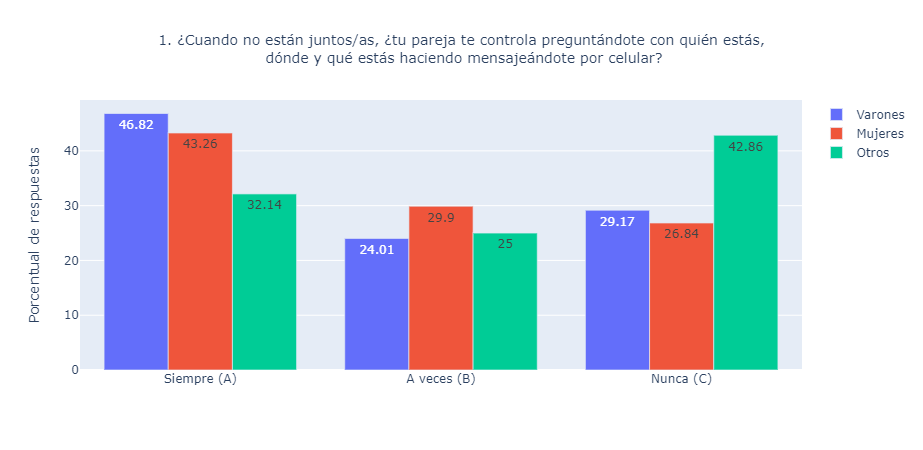

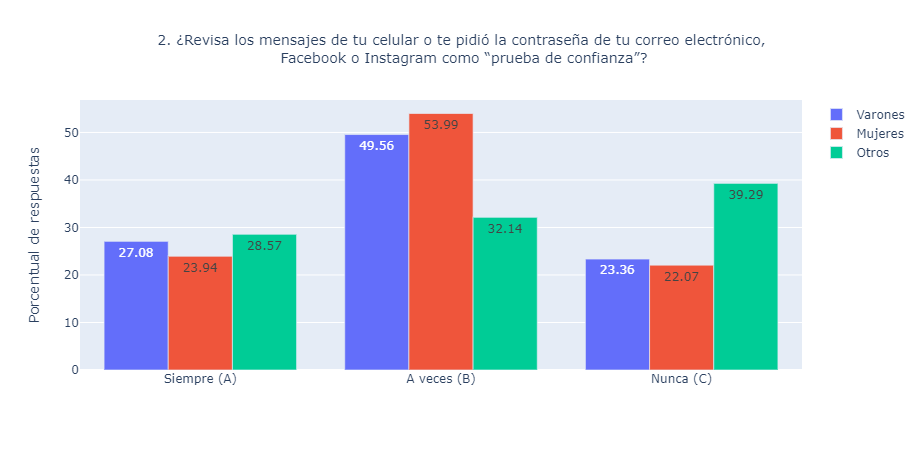

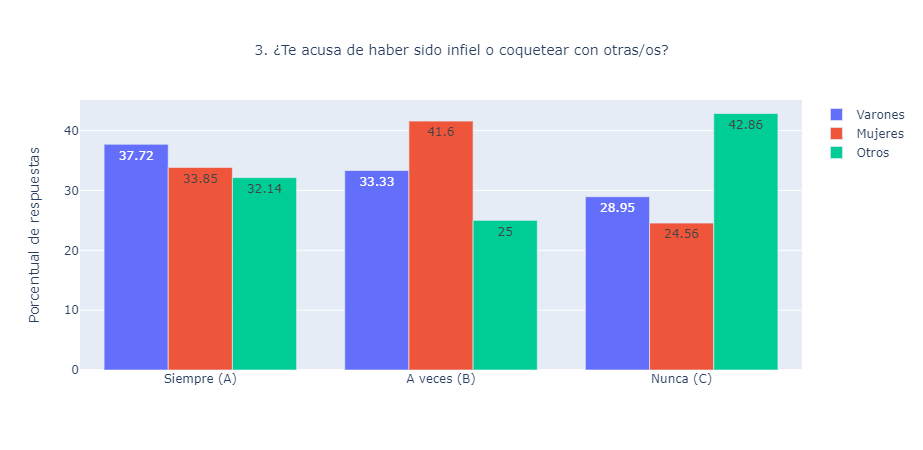

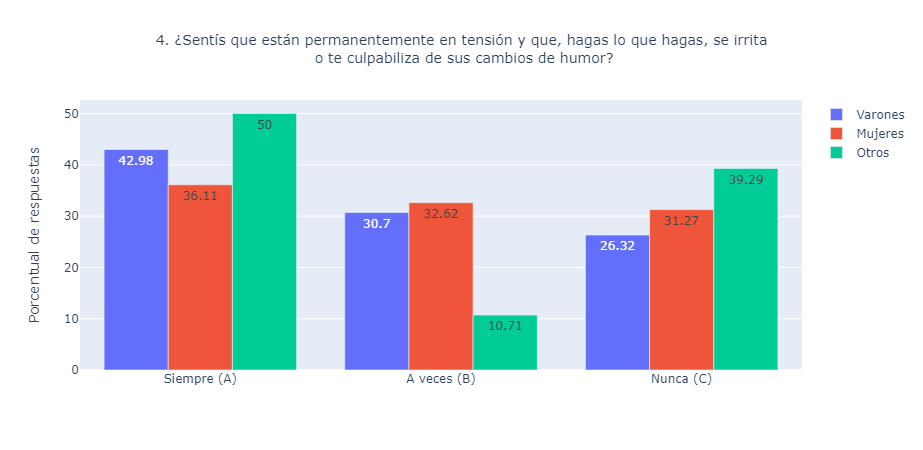

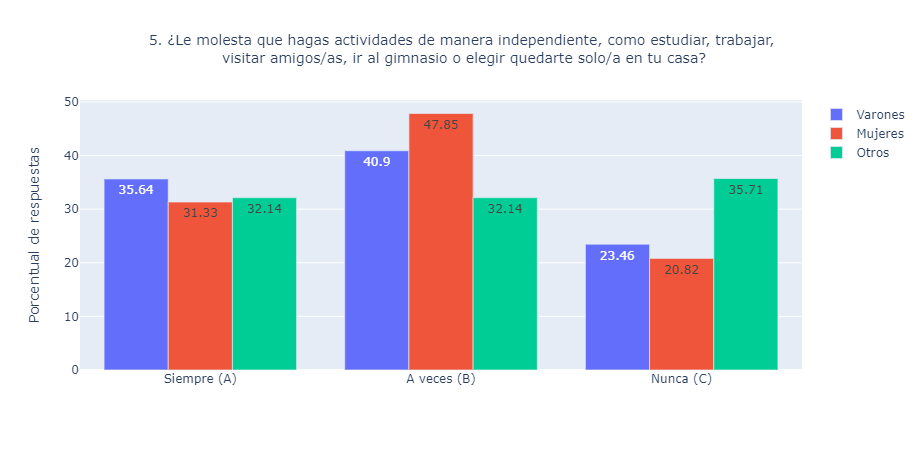

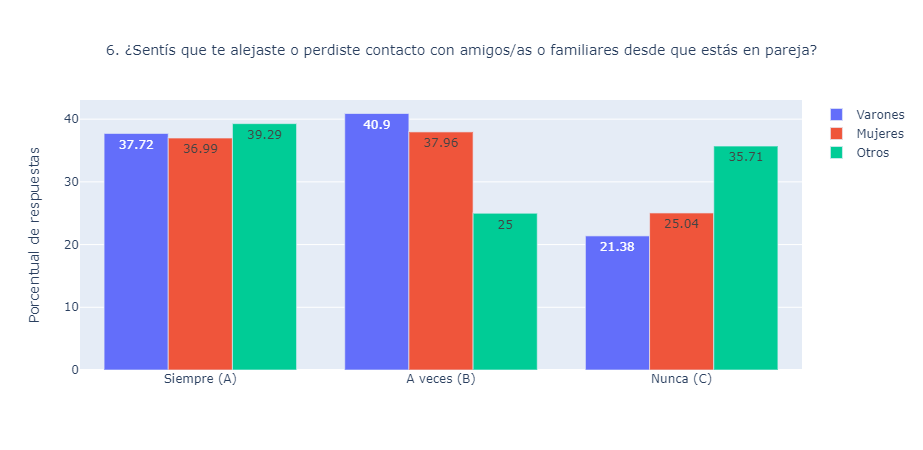

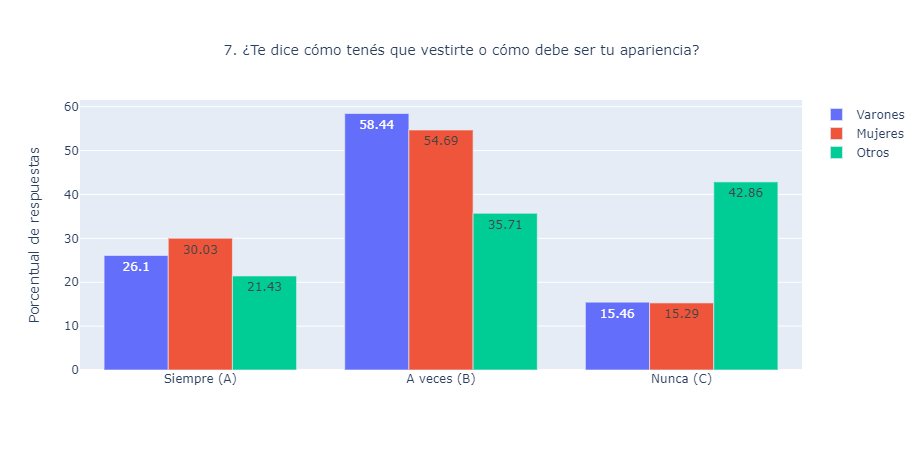

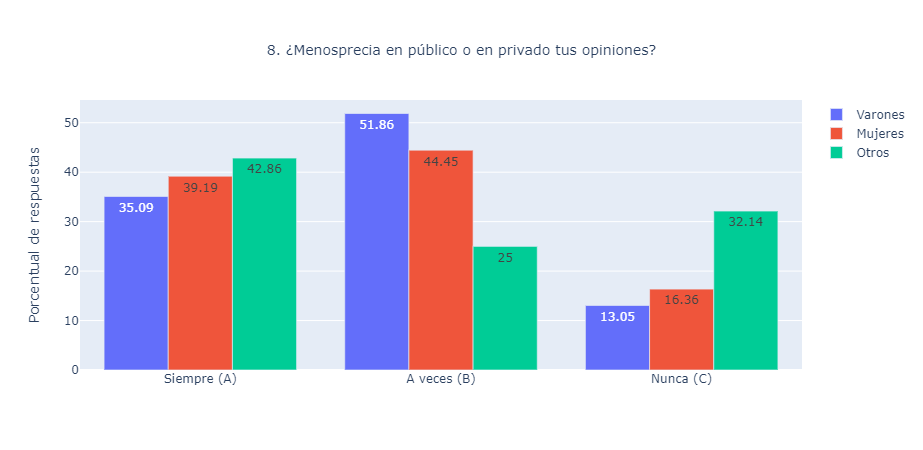

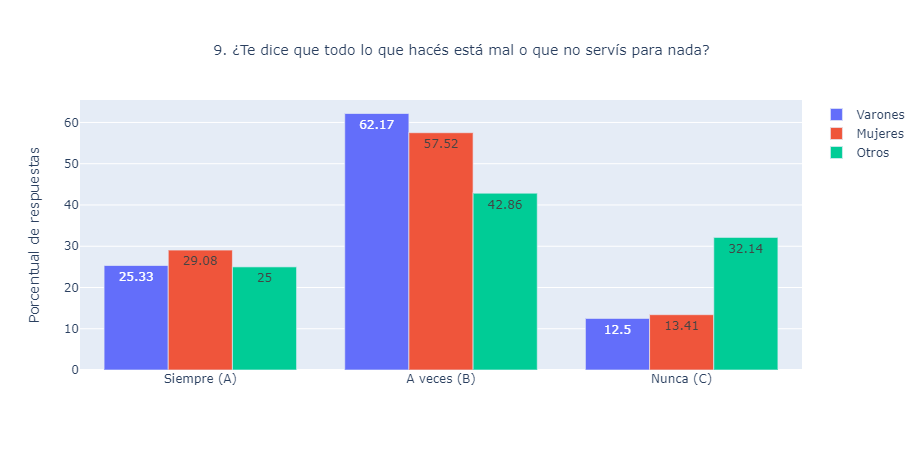

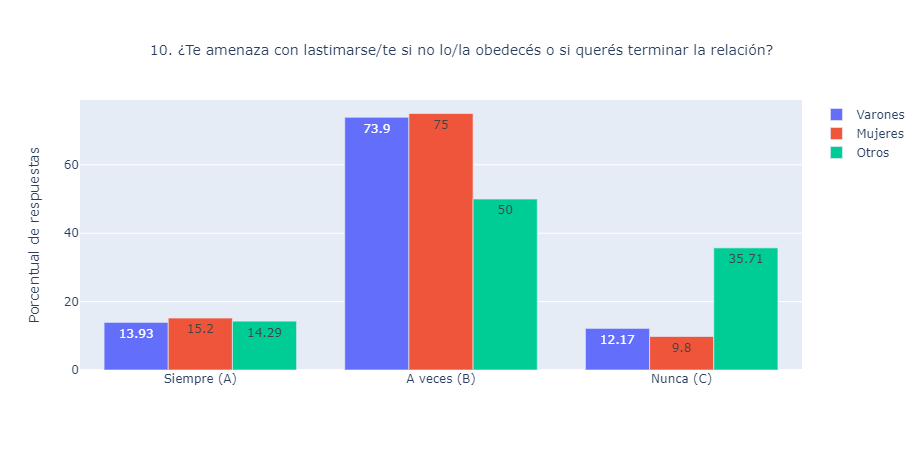

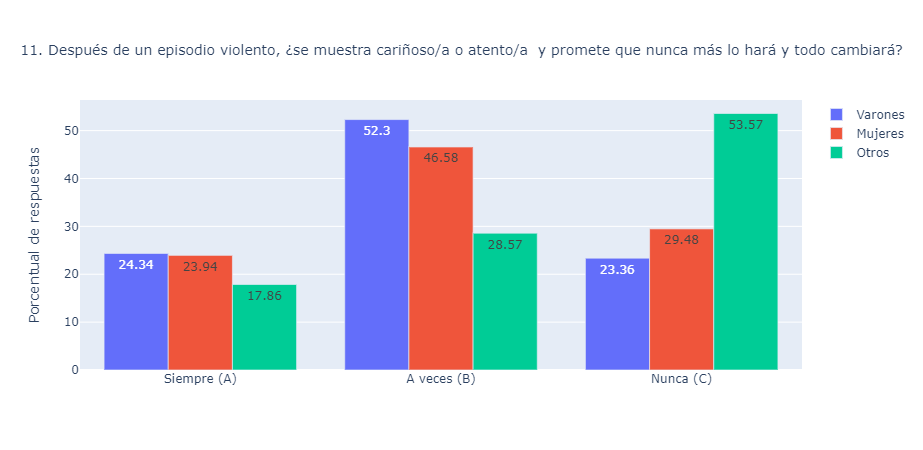

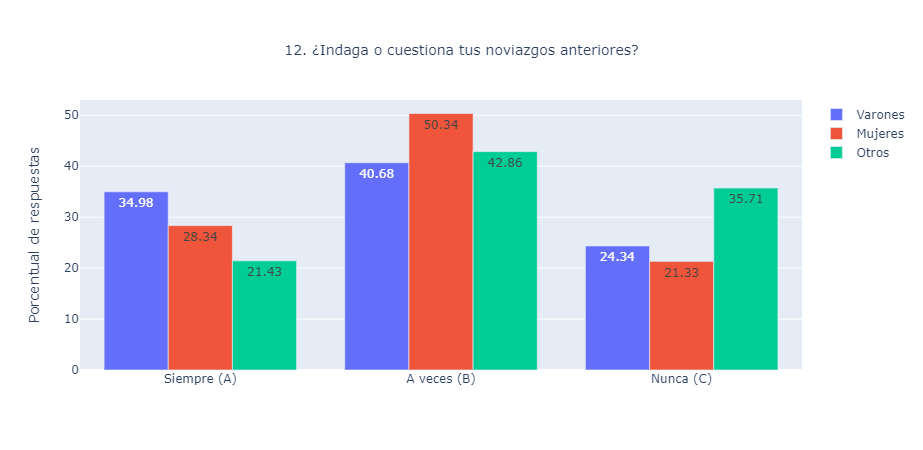

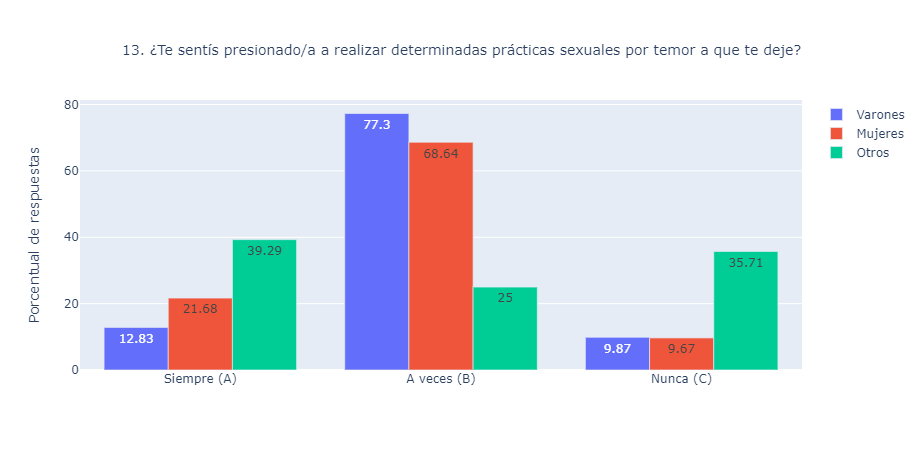

In [167]:
for i, columna in enumerate(data.drop('genero',axis=1).columns):
    varones = list(data.groupby(columna).genero.value_counts())[1::3] / (data.genero == 'Hombre').sum()
    mujeres = list(data.groupby(columna).genero.value_counts())[::3] / (data.genero == 'Mujer').sum()
    otros = list(data.groupby(columna).genero.value_counts())[2::3] / (data.genero == 'Otro').sum()
    fig = go.Figure(data=[
    go.Bar(name='Varones', x=respuestas, y=varones*100, text=np.around(varones*100,2), textposition='auto'),
    go.Bar(name='Mujeres', x=respuestas, y=mujeres*100,text=np.around(mujeres*100,2), textposition='auto'),
    go.Bar(name='Otros', x=respuestas, y=otros*100, text=np.around(otros*100,2), textposition='auto')
    ])
    fig.update_layout(barmode='group',
        title={
        'text': preguntas[i],
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
        'size': 14}},
        yaxis= {
        'title': {
        'text': 'Porcentual de respuestas'}})
    fig.show()


In [81]:
list(data.groupby('pregunta_7').genero.value_counts())

[1422, 238, 6, 2590, 533, 10, 724, 141, 12]

#### Respuestas según género

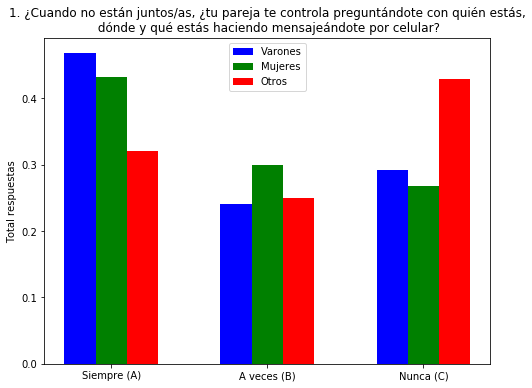

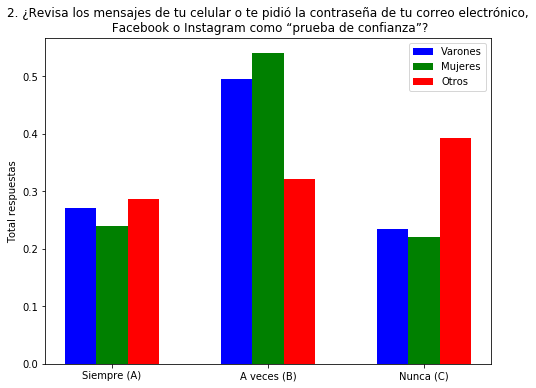

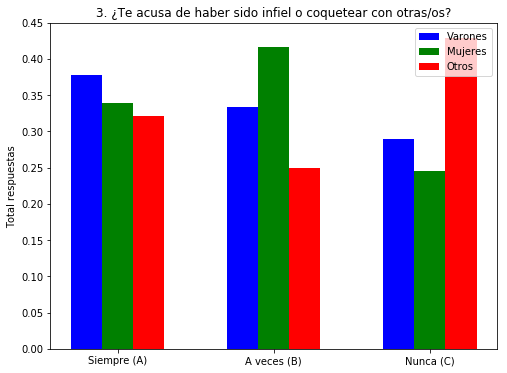

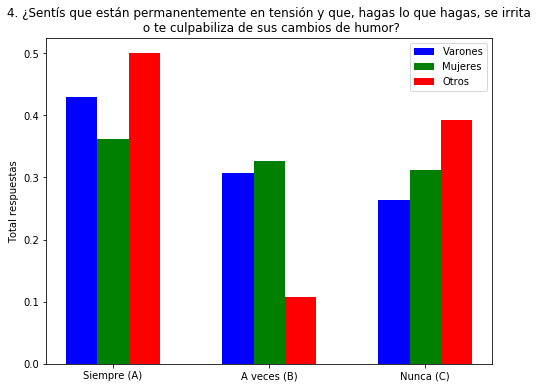

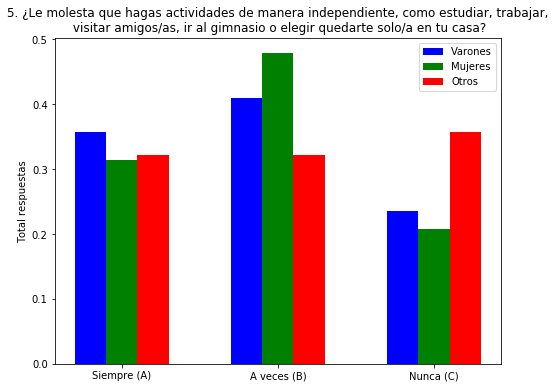

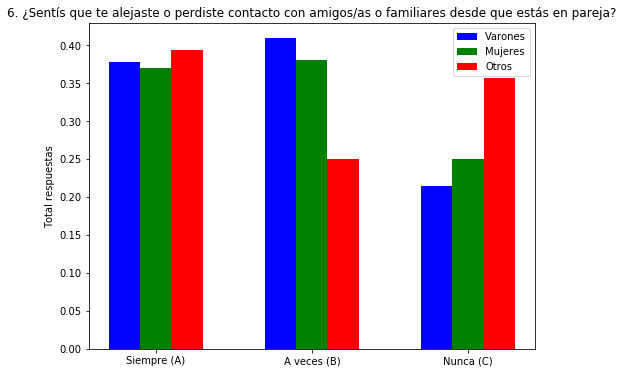

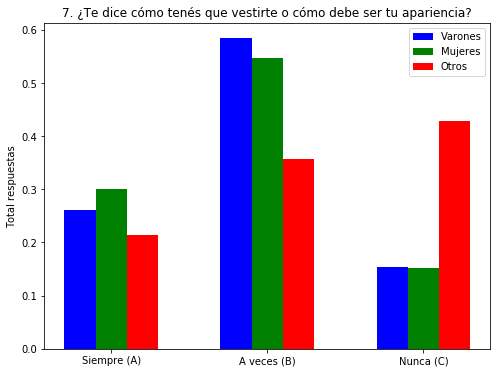

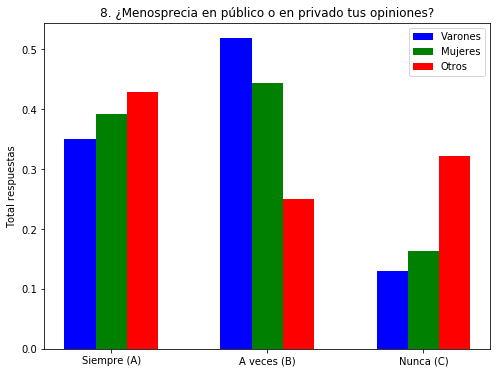

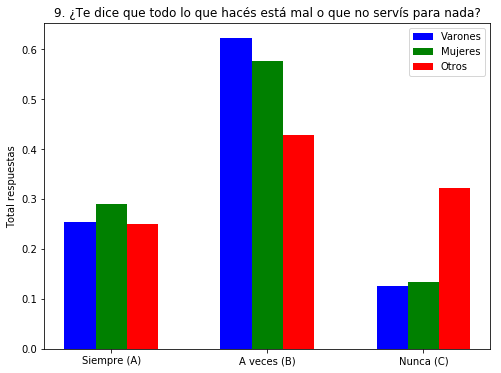

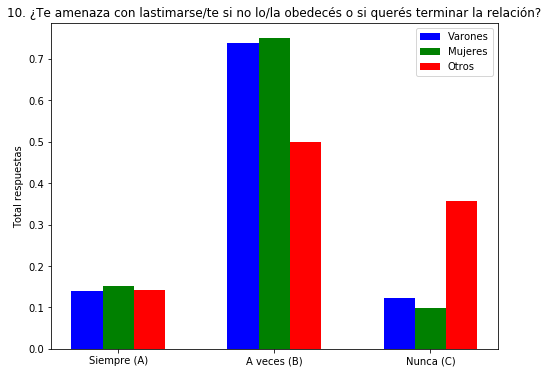

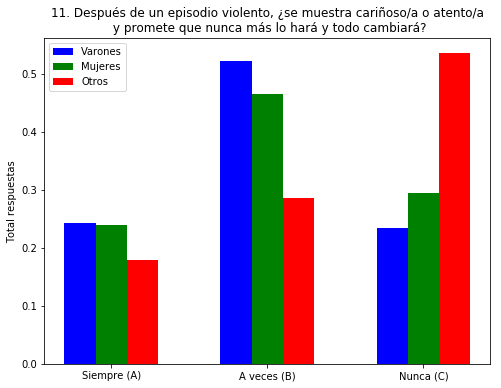

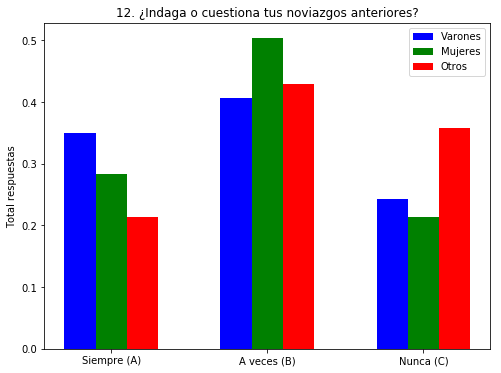

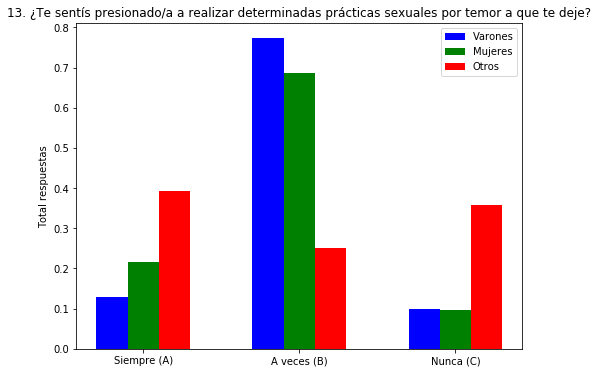

In [36]:
for num,columna in enumerate(data.drop('genero',axis=1).columns):
    respuesta = set(np.array(list(data.groupby(columna).genero.value_counts().index))[:,0])
    # respuesta por hombres
    n_varones = (data.genero == 'Hombre').sum()
    n_mujeres = (data.genero == 'Mujer').sum()
    n_otros = (data.genero == 'Otro').sum()
    varones = list(data.groupby(columna).genero.value_counts())[1::3] / n_varones
    # respusta por mujeres
    mujeres = list(data.groupby(columna).genero.value_counts())[::3] / n_mujeres 
    # respusta por otros
    otros = list(data.groupby(columna).genero.value_counts())[2::3] / n_otros

    x = np.arange(len(respuesta))
    width = 0.2

    fig, ax = plt.subplots(figsize=(8,6))
    barra1 = ax.bar(x, varones, width, label='Varones', color='blue')
    barra2 = ax.bar(x+0.2, mujeres, width, label='Mujeres', color='green')
    barra3 = ax.bar(x+0.4, otros, width, label='Otros', color='red')

    ax.set_ylabel('Total respuestas')
    ax.set_title(preguntas[num])
    ax.set_xticks(x+0.2)
    ax.set_xticklabels(respuestas)
    ax.legend()

### <a id="section_split">1.3 Selección de Target</a> 

Seleccionamos el target (columna: 'df.pregunta_13') y lo transformamos en dicotómico. Descartamos la respuesta "intermedia", considerado "A veces" como "Siempre".

In [36]:
data.pregunta_13.value_counts()

Nunca      3963
A veces    1155
Siempre     558
Name: pregunta_13, dtype: int64

In [37]:
# agrego el target al dataframe
dataset['target'] = dataset.pregunta_13 != 'C'

In [38]:
# agrego el target al dataframe al dataframe destinado al ploteo para ver distribución de las respuestas
data['target']  = dataset.target.apply(lambda x: 'Nunca' if x is False else 'Siempre')

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
data.target.value_counts()

Nunca      3963
Siempre    1713
Name: target, dtype: int64

#### Observamos la distribución de las respuestas del target (según género)

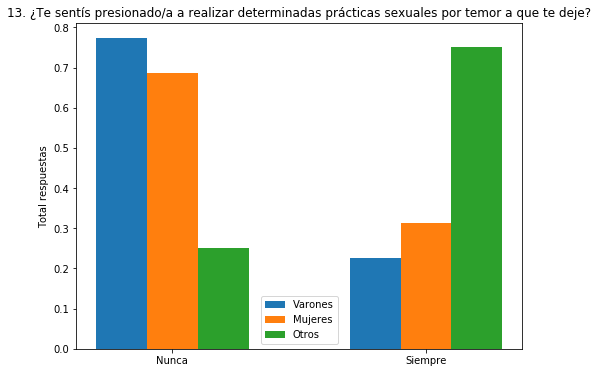

In [40]:
fig, ax = plt.subplots(figsize=(8,6))

respuesta = list(data.target.value_counts().index)

n_varones = (data.genero == 'Hombre').sum()
n_mujeres = (data.genero == 'Mujer').sum()
n_otros = (data.genero == 'Otro').sum()

varones = list(data.groupby('target').genero.value_counts())[1::3] / n_varones
mujeres = list(data.groupby('target').genero.value_counts())[::3] / n_mujeres 
otros = list(data.groupby('target').genero.value_counts())[2::3] / n_otros

x = np.arange(len(respuesta))
width = 0.2

barra1 = ax.bar(x, varones, width, label='Varones')
barra2 = ax.bar(x+0.2, mujeres, width, label='Mujeres')
barra3 = ax.bar(x+0.4, otros, width, label='Otros')

ax.set_ylabel('Total respuestas')
ax.set_title(preguntas[12])
ax.set_xticks(x + 0.2)
ax.set_xticklabels(respuesta)
ax.legend()

Observamos que los casos negativos son mayoría, salvo entre quienes declararon "Otros" en la pregunta sobre el género

#### Cruzamos las respuestas con el target
Distribuimos las respuestas de cada pregunta según el target

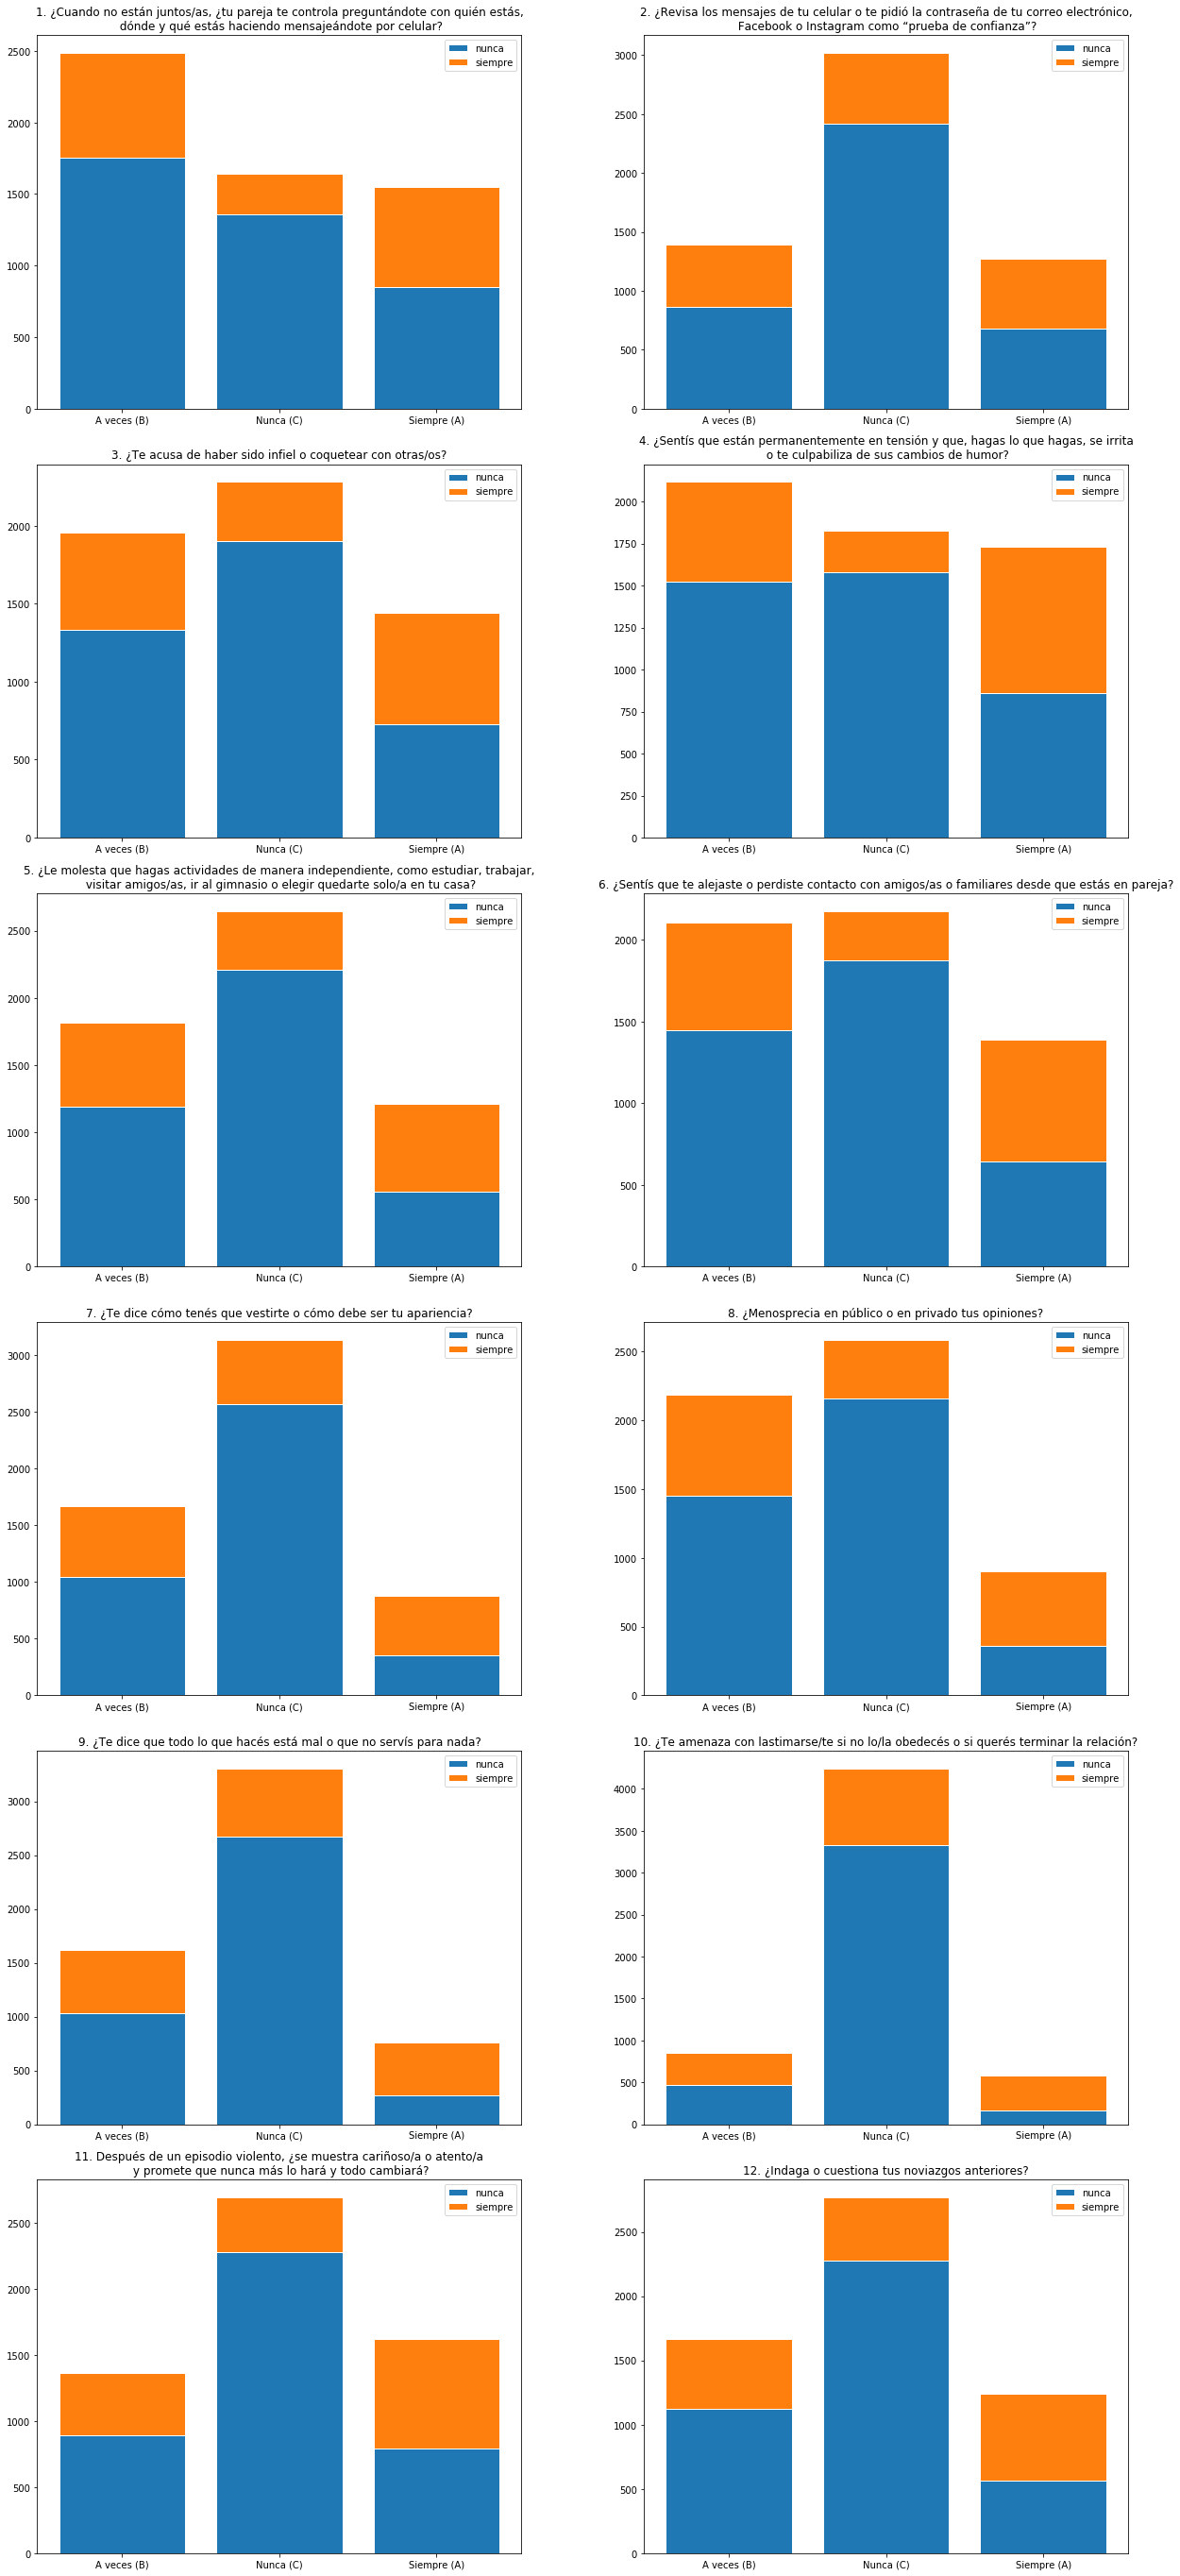

In [41]:
f, axes = plt.subplots(6, 2, figsize=(18, 38))
# posición de las barras en el eje x
x = [0,1,2]

for columna, ax, i in zip(data.columns[1:13], axes.flatten(), list(range(0,12))):
    # lista de tres elementos de la pregunta_x agrupados según el target
    nunca_bar = list(list(data.groupby('target')[columna].value_counts().sort_index()))[:3]
    siempre_bar = list(list(data.groupby('target')[columna].value_counts().sort_index()))[3:6]
    ax.bar(x, nunca_bar, edgecolor='white', tick_label=sorted(respuestas))
    # Create green bars (middle), on top of the firs ones
    ax.bar(x, siempre_bar, bottom=nunca_bar, edgecolor='white', tick_label=sorted(respuestas))

    # Custom X axis
    #ax.set_xticks(x, sorted(respuestas))
    ax.legend(labels=['nunca', 'siempre'])
    ax.set_title(preguntas[i])

plt.tight_layout()
plt.show()

<hr>